In [ ]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import warnings
import pandas as pd
warnings.filterwarnings("ignore", category=FutureWarning)
from keras.models import Sequential
import tensorflow as tf

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

In [ ]:
#sending a request and storing the return
req =  Request('https://in.investing.com/commodities/brent-oil-historical-data?end_date=1682101800&interval_sec=monthly&st_date=347135400',headers= {'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()

In [ ]:
#changing response to lxml
soup = BeautifulSoup(webpage,'lxml')

In [ ]:
table = soup.find('table',{'class':'common-table medium js-table'})

In [ ]:
rows = table.findAll('tr')

In [ ]:
rows
all_rows = []
for row in rows:
  single_row = row.findAll('td')
  all_rows.append(single_row)

In [ ]:
df = []
for row in all_rows:
  data = []
  for column in row:
    data.append(column.getText())
  df.append(data)

In [ ]:
df = pd.DataFrame(df)

In [ ]:
df.columns = ["date","price","open","high","low","volume","chg"]

In [ ]:
df = df.drop(index =0) #dropping the first row

In [ ]:
df.date = df.date.str.replace('\n',"")
df.price = df.price.str.replace('\n',"")
df.open = df.open.str.replace('\n',"")
df.high = df.high.str.replace('\n',"")
df.low = df.low.str.replace('\n',"")
df.volume = df.volume.str.replace('\n',"")
df.chg = df.chg.str.replace('\n',"")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 1 to 418
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    418 non-null    object
 1   price   418 non-null    object
 2   open    418 non-null    object
 3   high    418 non-null    object
 4   low     418 non-null    object
 5   volume  418 non-null    object
 6   chg     418 non-null    object
dtypes: object(7)
memory usage: 23.0+ KB


In [ ]:
df  = df[['date','open']]

In [ ]:
df['date'] = df['date'].astype("datetime64[ns]") #changing type

<ipython-input-14-d391141fccf9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype("datetime64[ns]") #changing type


In [ ]:
df['open'] = df['open'].astype("float") #changing type

<ipython-input-15-cead1f2b8245>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['open'] = df['open'].astype("float") #changing type


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 1 to 418
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    418 non-null    datetime64[ns]
 1   open    418 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.7 KB


In [ ]:
#changing index ti\o datetime
df.set_index('date',inplace=True)

In [ ]:
df = df.sort_index()

<Axes: xlabel='date'>

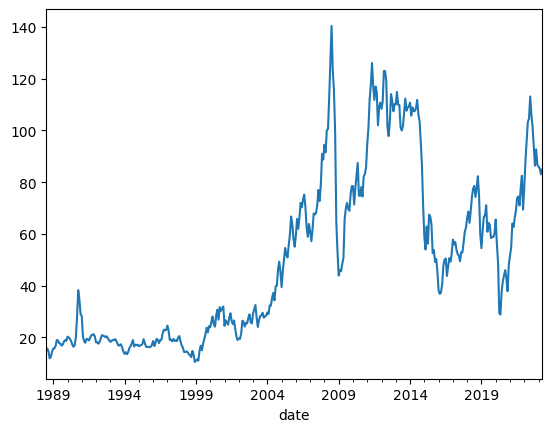

In [ ]:
df.open.plot()

In [ ]:
#Degrading into trendm, seasonal and residual
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_result = seasonal_decompose(df.open,model="multiplicative")

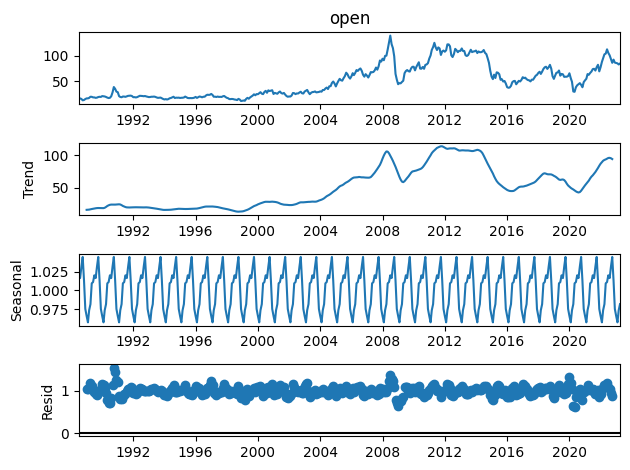

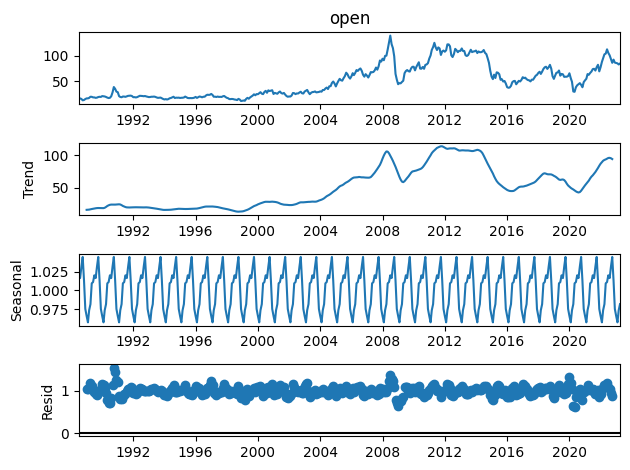

In [ ]:
decomp_result.plot()

In [ ]:
train = df.loc[:"2018"]
test = df.loc["2019"]

In [ ]:
train

,open
date,
1988-07-01,14.60
1988-08-01,15.64
1988-09-01,14.50
1988-10-01,11.83
1988-11-01,12.45
...,...
2018-08-01,74.25
2018-09-01,77.57
2018-10-01,82.30


In [ ]:
train['sma'] = train.open.rolling(window=12).mean()

<ipython-input-24-095b626ac815>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sma'] = train.open.rolling(window=12).mean()


In [ ]:
train

,open,sma
date,,
1988-07-01,14.60,NaN
1988-08-01,15.64,NaN
1988-09-01,14.50,NaN
1988-10-01,11.83,NaN
1988-11-01,12.45,NaN
...,...,...
2018-08-01,74.25,67.071667
2018-09-01,77.57,69.137500
2018-10-01,82.30,71.284167


In [ ]:
#Predicting from SMA
def SMA_prediction(periods):
  train1 = train.sma.values
  train2 = train1.tolist()
  pred = []
  for i in range(periods):
    c_batch = train2[-1*36:]
    next_pred = sum(c_batch) /36
    train2.append(next_pred)
    pred.append(next_pred)
  return pred
  


test['SMA_prediction'] = SMA_prediction(12)

<Axes: xlabel='date'>

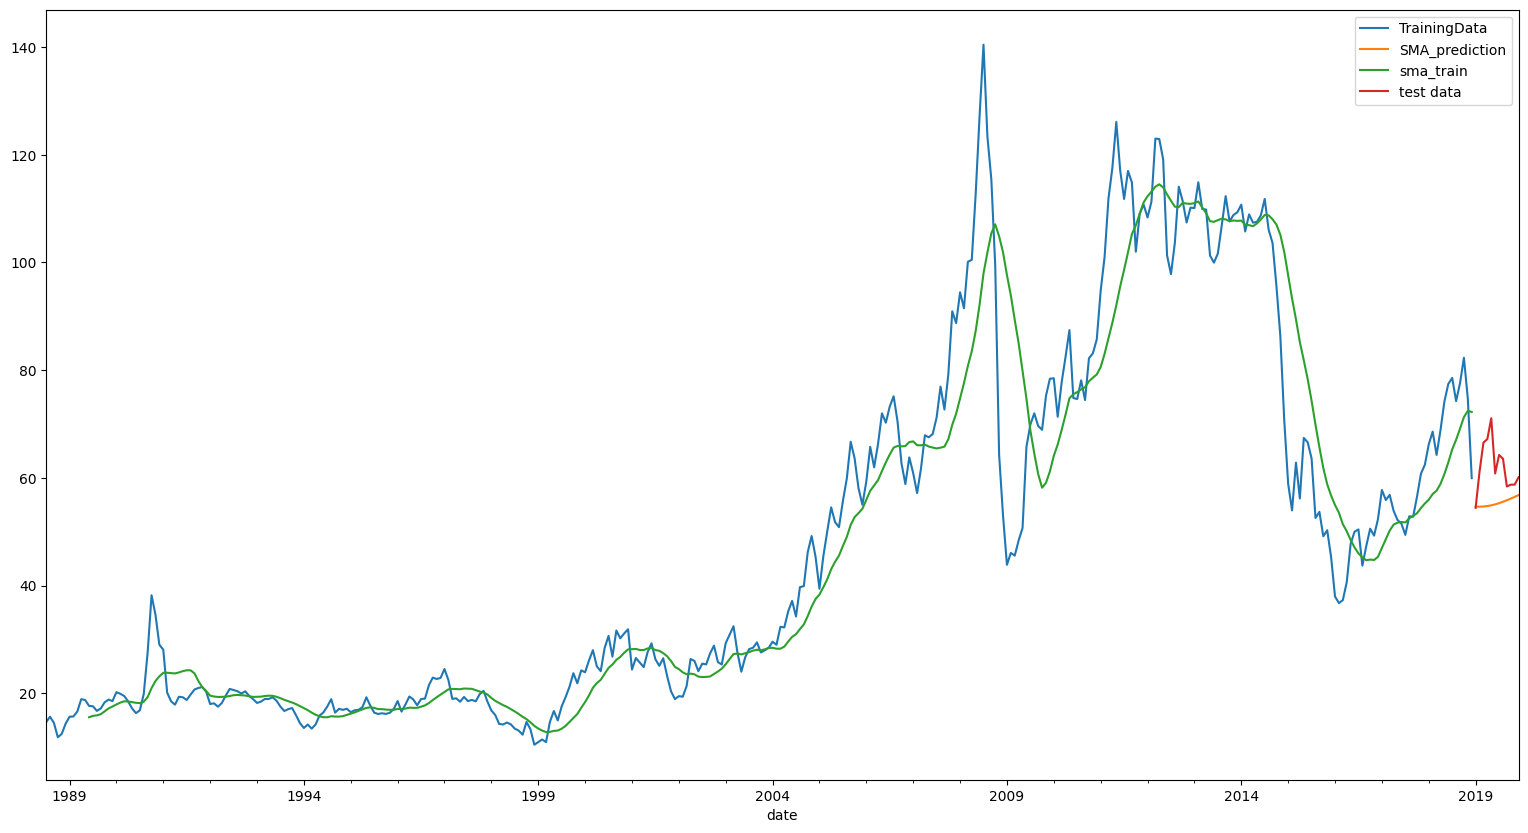

In [ ]:
#Visualise
train.open.plot(legend=True,label="TrainingData",figsize = (19,10))
test.SMA_prediction.plot(legend=True,label="SMA_prediction",figsize = (19,10))
train.sma.plot(legend=True,label="sma_train",figsize = (19,10))
test.open.plot(legend=True,label="test data",figsize = (19,10))

#Scaling Data
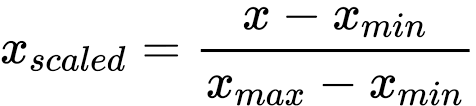

In [ ]:
# Scale Data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#this is fitting
scaler = MinMaxScaler()
scaler.fit(train[['open']])

MinMaxScaler()

In [ ]:
#this is transformation
scaled_train = scaler.transform(train[["open"]])
scaled_test = scaler.transform(test[["open"]])


In [ ]:
scaled_test

array([[0.33846154],
       [0.39007692],
       [0.43153846],
       [0.43669231],
       [0.46638462],
       [0.38746154],
       [0.41392308],
       [0.40861538],
       [0.36892308],
       [0.37153846],
       [0.37153846],
       [0.38215385]])

Time series Generatoe
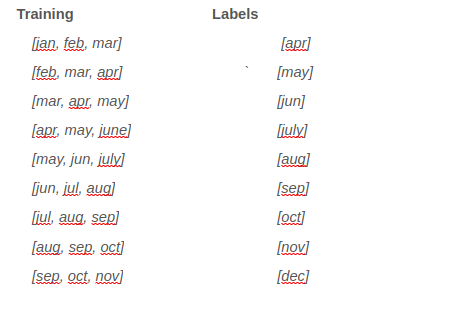

In [ ]:
#Time series generator
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator
n_input = 50
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
#define model
model = Sequential()
model.add(LSTM(50,activation="relu",input_shape=(n_input,1),return_sequences=True)) ##########Why return sequence as true here?################
model.add(LSTM(50,activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit_generator(generator,epochs=20)

Epoch 1/20


<ipython-input-43-a09c067c5dfd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20)


316/316 [==============================] - 16s 40ms/step - loss: 0.0206
Epoch 2/20
316/316 [==============================] - 13s 40ms/step - loss: 0.0106
Epoch 3/20
316/316 [==============================] - 13s 40ms/step - loss: 0.0085
Epoch 4/20
316/316 [==============================] - 14s 44ms/step - loss: 0.0067
Epoch 5/20
316/316 [==============================] - 13s 40ms/step - loss: 0.0057
Epoch 6/20
316/316 [==============================] - 13s 40ms/step - loss: 0.0047
Epoch 7/20
316/316 [==============================] - 13s 40ms/step - loss: 0.0038
Epoch 8/20
316/316 [==============================] - 13s 40ms/step - loss: 0.0037
Epoch 9/20
316/316 [==============================] - 13s 40ms/step - loss: 0.0030
Epoch 10/20
316/316 [==============================] - 17s 53ms/step - loss: 0.0031
Epoch 11/20
316/316 [==============================] - 13s 40ms/step - loss: 0.0026
Epoch 12/20
316/316 [==============================] - 13s 40ms/step - loss: 0.0026
Epoch 13/20


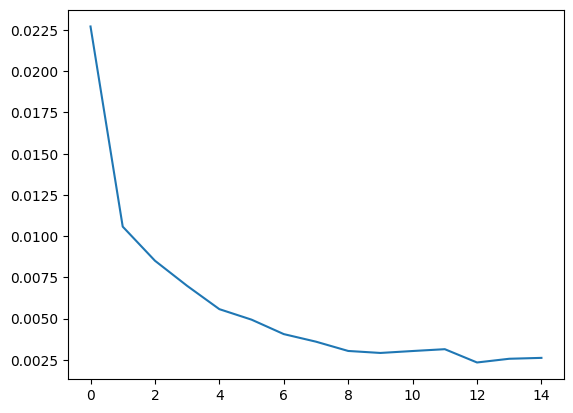

In [ ]:
import matplotlib.pyplot as plt


loss_per_epoch = model.history.history['loss']

plt.plot(range(len(loss_per_epoch)),loss_per_epoch)


In [ ]:
# jan feb march >>>> april(predicted)
#feb march april(predicted) >>>>>>>>> may(predicted)
#march april(predicted) may(predicted) >>>>>> june(predicted)
# prediction prediction prediction >>>>>>>>>>> prediction

import numpy as np

test_prediction = []
first_batch = scaled_train[-1*n_input:]
curr_batch = first_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
  curr_pred = model.predict(curr_batch)[0]
  test_prediction.append(curr_pred)

  curr_batch = np.append(curr_batch[:,1:,:],[[curr_pred]],axis=1)

1/1 [==============================] - 0s 30ms/step


In [ ]:
#Transforming data back to un-Scaled version 
true_predictions = scaler.inverse_transform(test_prediction)

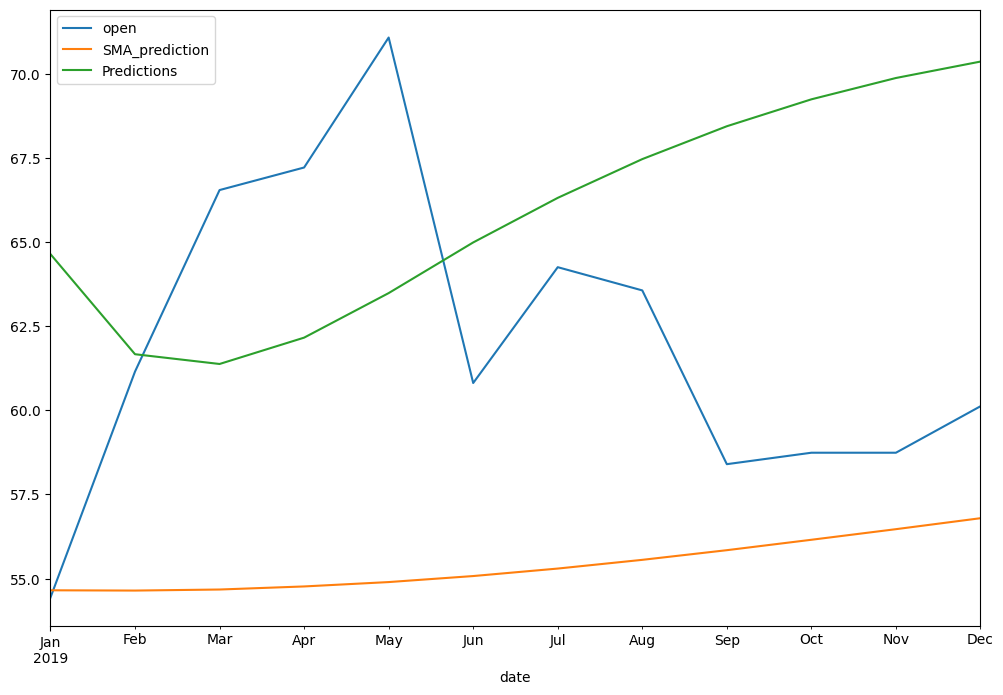

In [ ]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions
test.plot(figsize=(12,8));

## Homework </br> In the note book above models have been just trained and results visualised, you need to come up with a metric and compare the two results.